In [1]:
import os
import pandas as pd
import numpy as np

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [2]:
def group_f1_w(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.f1_score(label, pred, average='macro')
    return score

def group_kappa_w(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.cohen_kappa_score(label, pred, weights='linear')
    return score

def group_auc_w(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = [np.array(i.split(','), dtype=float) for i in df.Pred.tolist()]
    try: 
        score = metrics.roc_auc_score(label, pred, multi_class='ovr', average='macro', labels=[0, 1, 2, 3])
    except:
        score = np.nan
    return score

In [3]:
def group_f1(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = [np.array(i.split(','), dtype=float) for i in df.Pred.tolist()]
    try: 
        score = metrics.roc_auc_score(label, pred, multi_class='ovr', average='micro', labels=[0, 1, 2, 3])
    except:
        score = np.nan
    return score

In [4]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    pred_b = softmax(pred_b)
    return pred_b[1] # the probability to greater label

In [5]:
def convert2cls(chir, csp_category): 
    if csp_category == '1' or csp_category == 1: 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2' or csp_category == 2: 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

## 1. Load prediction results

In [6]:
dfs = []
for mb in range(18): 
    dfs.append(pd.read_csv('../results0724/molnet_cmrt_cls_etkdg_csp{}.csv'.format(str(mb)), 
                               sep='\t', index_col=0))
    df_pred = pd.concat(dfs, ignore_index=True)

In [7]:
df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)

In [8]:
df_pred = df_pred.sort_values(['SMILES', 'MB', 'Pred_b'], 
                              ascending=False).drop_duplicates(['SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [9]:
df_pred

,SMILES,MB,Pred,Pred_b
0,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,0,"1.383542326038878e-06,0.00012394781515467912,0...",0.731009
1,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,0,"1.8143120996683137e-06,0.9998632669448853,0.00...",0.268994
2,Cc1ccc(S(=O)(=O)CC2CCCc3ccccc32)cc1,0,"5.411935035226634e-06,0.9996316432952881,0.000...",0.269084
3,Cc1ccc(S(=O)(=O)CC(C)c2cccs2)cc1,0,"7.844288120395504e-06,0.9997090697288513,0.000...",0.269053
4,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Br)cc2)cc1,0,"2.080532567561022e-06,0.9995738863945007,0.000...",0.269108
...,...,...,...,...
48649,C=CC=CC[C@@](C=O)(CC)c1ccccc1,17,"0.12483806163072586,0.005629566963762045,0.547...",0.676791
48650,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,17,"0.0010032326681539416,1.0803406439663377e-05,0...",0.730660
48651,CC(=O)NN[C@H](C=Cc1ccccc1)c1ccc(C)cc1,17,"0.20063140988349915,0.004379616118967533,0.790...",0.643360
48652,O=C1OC(N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccccc21,17,"0.0007865028455853462,8.462171535938978e-06,0....",0.730746


## 2. Load CMRT

In [10]:
suppl = Chem.SDMolSupplier("../data/CMRT/cmrt_clean.sdf")
mols = [x for x in suppl if x is not None]

In [11]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)

df_label = pd.DataFrame.from_dict(df_dict)

In [12]:
df_label = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], 
                              ascending=False).drop_duplicates(['SMILES', 'MB'], 
                                                               keep='first').sort_index()

In [13]:
df_label

,SMILES,MB,K2/K1,Y
0,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,16,0.7792,0
1,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Cl)cc2)cc1,16,0.3095,0
2,Cc1ccc(S(=O)(=O)CC2CCCc3ccccc32)cc1,0,2.7838,3
3,Cc1ccc(S(=O)(=O)CC(C)c2cccs2)cc1,16,1.2706,2
4,Cc1ccc(S(=O)(=O)CC(C)c2ccc(Br)cc2)cc1,16,1.3404,2
...,...,...,...,...
2698,C=CC=CCC(C=O)(CC)c1ccccc1,9,1.0808,1
2699,CC1(Nc2ccccc2I)C(=O)Nc2ccccc21,0,1.4901,2
2700,CC(=O)NNC(C=Cc1ccccc1)c1ccc(C)cc1,6,1.0833,1
2701,O=C1OC(N(Cc2ccccn2)S(=O)(=O)c2ccccc2)c2ccccc21,16,1.2459,2


## 3. Merge

In [14]:
df_csp = pd.read_csv('../preprocess/chirality_stationary_phase_list.csv').dropna()

Convert isomer SMILES into regular SMILES

In [15]:
df_pred['SMILES'] = df_pred['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_label['SMILES'] = df_label['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [16]:
df_pred['MB'] = df_pred['MB'].astype(int)
df_label['MB'] = df_label['MB'].astype(int)

df_cmrt = df_pred.merge(df_label, on=['SMILES', 'MB'], how='right')

Calculate metrics (AUC, ACC, KAPPA, F1, COUNT)

In [17]:
df_cmrt['Class_b'] = df_cmrt['Y'].apply(binary_cls)

df_cmrt['Class'] = df_cmrt['Y']

In [18]:
auc = df_cmrt.groupby('MB').apply(group_auc)
acc = df_cmrt.groupby('MB').apply(group_acc)
kappa = df_cmrt.groupby('MB').apply(group_kappa)
f1 = df_cmrt.groupby('MB').apply(group_f1)
cnt = df_cmrt.groupby('MB').size()

auc_w = df_cmrt.groupby('MB').apply(group_auc_w)
kappa_w = df_cmrt.groupby('MB').apply(group_kappa_w)
f1_w = df_cmrt.groupby('MB').apply(group_f1_w)

In [19]:
df_res_all = pd.concat([auc, acc, kappa, f1, cnt, 
                        auc_w, kappa_w, f1_w], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT', 
                                                     'AUC_w', 'KAPPA_w', 'F1_w'], axis=1)
df_res_all.reset_index(inplace=True)
df_res_all = df_res_all.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT',
                                         5: 'AUC_w', 6: 'KAPPA_w', 7: 'F1_w'})

df_res_all = df_res_all.merge(df_csp, left_on='MB', right_on='CSP_Encode')

In [20]:
df_res_all

,MB,AUC,ACC,KAPPA,F1,COUNT,AUC_w,KAPPA_w,F1_w,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category
0,0,0.814739,0.624561,0.091843,0.624561,285,0.591084,0.080770,0.308000,Chiralpak IB,IB,91423,0,2
1,6,0.712932,0.514563,0.024806,0.514563,103,NaN,0.017077,0.250354,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2
2,8,0.786968,0.616279,0.032720,0.616279,172,0.443935,0.027027,0.275155,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2
3,9,0.769189,0.500000,0.114382,0.500000,152,0.608602,0.131714,0.330134,Chiralpak AS,AS,45167,9,2
4,11,0.778473,0.612546,0.137021,0.612546,271,NaN,0.141786,0.315112,Chiralpak AD,AD,23735,11,2
5,14,0.719184,0.481605,0.061895,0.481605,897,0.537245,0.092364,0.308214,Chiralpak IC (Sepapak 5),IC,91518,14,1
6,16,0.718251,0.465116,0.061097,0.465116,731,0.572235,0.073749,0.281257,Chiralpak IA,IA,45172,16,1


Calculate \#Class1 / \#Class0

In [21]:
df_res_all_class_cnt = df_cmrt.groupby('MB').value_counts(subset=['Class_b']).reset_index()

df_res_all_class_ratio = df_res_all_class_cnt.groupby('MB').apply(lambda x: 
                x[x['Class_b'] == 0]['count'].values[0] / x[x['Class_b'] == 1]['count'].values[0]).to_frame(name='Class1/Class0')

df_res_all = df_res_all.merge(df_res_all_class_ratio, on='MB')

In [22]:
df_res_all

,MB,AUC,ACC,KAPPA,F1,COUNT,AUC_w,KAPPA_w,F1_w,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category,Class1/Class0
0,0,0.814739,0.624561,0.091843,0.624561,285,0.591084,0.080770,0.308000,Chiralpak IB,IB,91423,0,2,0.295455
1,6,0.712932,0.514563,0.024806,0.514563,103,NaN,0.017077,0.250354,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2,0.197674
2,8,0.786968,0.616279,0.032720,0.616279,172,0.443935,0.027027,0.275155,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2,0.237410
3,9,0.769189,0.500000,0.114382,0.500000,152,0.608602,0.131714,0.330134,Chiralpak AS,AS,45167,9,2,0.652174
4,11,0.778473,0.612546,0.137021,0.612546,271,NaN,0.141786,0.315112,Chiralpak AD,AD,23735,11,2,0.215247
5,14,0.719184,0.481605,0.061895,0.481605,897,0.537245,0.092364,0.308214,Chiralpak IC (Sepapak 5),IC,91518,14,1,0.560000
6,16,0.718251,0.465116,0.061097,0.465116,731,0.572235,0.073749,0.281257,Chiralpak IA,IA,45172,16,1,0.653846


### Check the results on overlapped molecules (CMRT & ChirBase)

In [23]:
df_overlap = pd.read_csv('../data/compare_chirbase_cmrt.csv')

df_overlap = df_overlap.sort_values(['SMILES', 'Column_x', 'K2/K1_x'], 
                              ascending=False).drop_duplicates(['SMILES', 'Column_x'], 
                                                               keep='first').sort_index()

df_overlap = df_overlap.merge(df_csp, left_on='Column_x', right_on='Short_Name', how='left')

df_overlap = df_overlap.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [24]:
df_overlap

,SMILES,Column_x,K2/K1_x,Column_y,K2/K1_y,Column_map,CSP_category,Y_x,Y_y,Y_x2,...,CSP_ID,CSP_Encode,CSP_Category,MB,Pred,Pred_b,K2/K1,Y,Class_b,Class
0,CCOC(=O)C(CNC(C)=O)(Sc1ccc(C)cc1)c1ccccc1,OD,1.308036,Chiralcel OD (Lux Cellulose-1),1.3092,OD,2,2,2,1,...,45173,8,2,8,"0.0003809384361375123,0.0004181947442702949,0....",0.730744,1.3080,2,1,2
1,CCOC(=O)C(C[N+](=O)[O-])(Sc1ccc(C(C)(C)C)cc1)c...,AS,1.259358,Chiralpak AS,1.2599,AS,2,2,2,1,...,45167,9,2,9,"1.3900295925850514e-05,0.9915577173233032,0.00...",0.272269,1.2594,2,1,2
2,CCOC(=O)C(C[N+](=O)[O-])(Sc1cc(C)cc(C)c1)c1ccccc1,AD,1.084337,Chiralpak AD,1.0845,AD,2,1,1,0,...,23735,11,2,11,"0.0018735264893621206,0.990399181842804,0.0058...",0.271991,1.0843,1,0,1
3,CCC(C#N)c1ccccc1,AS,1.340580,Chiralpak AS,1.3500,AS,2,2,2,1,...,45167,9,2,9,"0.0005602329620160162,0.003579522017389536,0.9...",0.729428,1.3406,2,1,2
4,CCOC(=O)C(C[N+](=O)[O-])(Sc1ccccc1C)c1ccccc1,AD,1.151104,Chiralpak AD,1.1513,AD,2,2,2,1,...,23735,11,2,11,"0.0013728252379223704,0.0019609129521995783,0....",0.729746,1.1511,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,OCC(O)(CSc1nc2cc(Cl)ccc2s1)c1ccccc1,IC,1.207547,Chiralpak IC (Sepapak 5),1.2079,IC,1,2,2,1,...,91518,14,1,14,"4.5264816435519606e-05,2.067537934635766e-05,0...",0.731033,1.2075,2,1,2
82,CCC=CC(=O)C(c1cccc(OC)c1)C(C(=O)c1ccc(Br)cc1)C...,IC,1.716418,Chiralpak IC (Sepapak 5),1.8388,IC,1,2,2,1,...,91518,14,1,14,"9.143313218373805e-05,3.8457283153547905e-06,0...",0.731021,1.7164,2,1,2
83,CCOC(=O)C1=C(C=Cc2ccccc2)OC(=O)CC1c1ccc(Cl)cc1,IA,1.190407,Chiralpak IA,1.1906,IA,1,1,1,0,...,45172,16,1,16,"5.797117410111241e-05,0.9998836517333984,9.968...",0.268964,1.1904,1,0,1
84,C=CCC(O)COCc1ccccc1,AS,1.254545,Chiralpak AS,1.1732,AS,2,2,2,1,...,45167,9,2,9,"0.0009848353220149875,0.8246003985404968,0.174...",0.342726,1.2545,2,1,2


Calculate metrics (Prediction v.s. CMRT labels)

In [25]:
df_overlap['Consistency'] = df_overlap.apply(lambda x: 1 if x['Y_x'] == x['Y_y'] else 0, axis=1)

In [26]:
auc = df_overlap.groupby('MB').apply(group_auc)
acc = df_overlap.groupby('MB').apply(group_acc)
kappa = df_overlap.groupby('MB').apply(group_kappa)
f1 = df_overlap.groupby('MB').apply(group_f1)
cnt = df_overlap.groupby('MB').size()

auc_w = df_cmrt.groupby('MB').apply(group_auc_w)
kappa_w = df_cmrt.groupby('MB').apply(group_kappa_w)
f1_w = df_cmrt.groupby('MB').apply(group_f1_w)

In [27]:
df_res = pd.concat([auc, acc, kappa, f1, cnt, 
                        auc_w, kappa_w, f1_w], names=['AUC', 'ACC', 'KAPPA', 'F1', 'COUNT', 
                                                     'AUC_w', 'KAPPA_w', 'F1_w'], axis=1)
df_res.reset_index(inplace=True)
df_res = df_res.rename(columns = {'index': 'MB', 0: 'AUC', 1: 'ACC', 2: 'KAPPA', 3: 'F1', 4: 'COUNT',
                                         5: 'AUC_w', 6: 'KAPPA_w', 7: 'F1_w'})

df_res_overlap = df_res.merge(df_csp, left_on='MB', right_on='CSP_Encode')

In [28]:
df_res_overlap_class_cnt = df_cmrt.groupby('MB').value_counts(subset=['Class_b']).reset_index()
df_res_overlap_class_ratio = df_res_overlap_class_cnt.groupby('MB').apply(lambda x: 
                x[x['Class_b'] == 0]['count'].values[0] / x[x['Class_b'] == 1]['count'].values[0]).to_frame(name='Class1/Class0')

df_red_overlap_consistency_ratio = df_overlap.groupby('MB').apply(lambda x: 
                    x['Consistency'].sum()/len(x['Consistency'])).reset_index().rename(columns={0: 'Consist_RATIO'})

df_res_overlap = df_res_overlap.merge(df_res_overlap_class_ratio, on='MB')
df_res_overlap = df_res_overlap.merge(df_red_overlap_consistency_ratio, on='MB')

In [29]:
df_res_overlap

,MB,AUC,ACC,KAPPA,F1,COUNT,AUC_w,KAPPA_w,F1_w,CSP,Short_Name,CSP_ID,CSP_Encode,CSP_Category,Class1/Class0,Consist_RATIO
0,6,0.893333,0.800000,0.000000,0.800000,5.0,NaN,0.017077,0.250354,Chiralcel OJ (Lux Cellulose-3),OJ,90246,6,2,0.197674,0.800000
1,8,0.906250,0.750000,0.000000,0.750000,8.0,0.443935,0.027027,0.275155,Chiralcel OD (Lux Cellulose-1),OD,45173,8,2,0.237410,0.875000
2,9,0.893491,0.615385,0.392523,0.615385,13.0,0.608602,0.131714,0.330134,Chiralpak AS,AS,45167,9,2,0.652174,0.846154
3,11,0.897959,0.785714,0.611111,0.785714,14.0,NaN,0.141786,0.315112,Chiralpak AD,AD,23735,11,2,0.215247,1.000000
4,14,0.993953,0.952381,0.929293,0.952381,21.0,0.537245,0.092364,0.308214,Chiralpak IC (Sepapak 5),IC,91518,14,1,0.560000,1.000000
5,16,0.960000,0.800000,0.620061,0.800000,25.0,0.572235,0.073749,0.281257,Chiralpak IA,IA,45172,16,1,0.653846,0.960000


### Plot!!

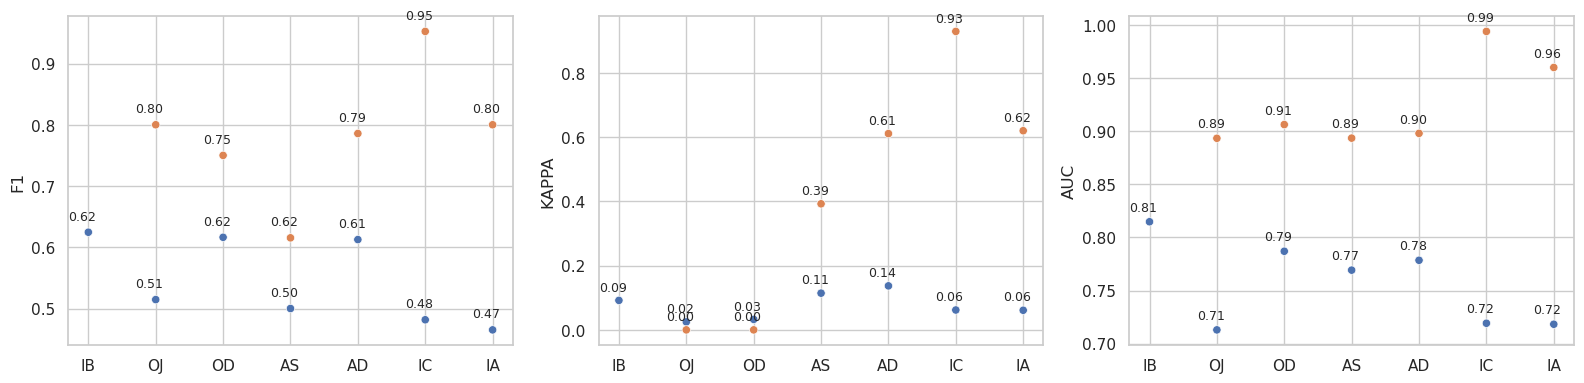

In [30]:
CSP_dict = {'IB': 0, 'OJ': 1, 'OD': 2, 'AS': 3, 'AD': 4, 'IC': 5, 'IA': 6}
# CSP_dict = {'OD': 0, 'AS': 1, 'AD': 2, 'IC': 3, 'IA': 4}
# IB: do not have overlap
# OJ: only have one positive sample
# OD: no positive samples

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

df_res_all['Label'] = 'All'
df_res_overlap['Label'] = 'Overlap'
df_res = pd.concat([df_res_all, df_res_overlap])
df_res_plot = df_res[df_res['Short_Name'].isin(CSP_dict.keys())]

sns.scatterplot(data=df_res_plot, x="Short_Name", y="AUC", hue='Label', ax=axs[2], legend=False)
axs[2].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="KAPPA", hue='Label', ax=axs[1], legend=False)
axs[1].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="F1", hue='Label', ax=axs[0], legend=False)
axs[0].set(xlabel=None)


for i, point in df_res_plot.iterrows(): 
    axs[2].text(CSP_dict[point['Short_Name']]-0.3, point['AUC']+0.01, '{:.2f}'.format(point['AUC']), fontsize=9)
    axs[1].text(CSP_dict[point['Short_Name']]-0.3, point['KAPPA']+0.03, '{:.2f}'.format(point['KAPPA']), fontsize=9)
    axs[0].text(CSP_dict[point['Short_Name']]-0.3, point['F1']+0.02, '{:.2f}'.format(point['F1']), fontsize=9)
    
fig.tight_layout()
plt.savefig('./test_cmrt.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./test_cmrt.png', dpi=600, bbox_inches='tight')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


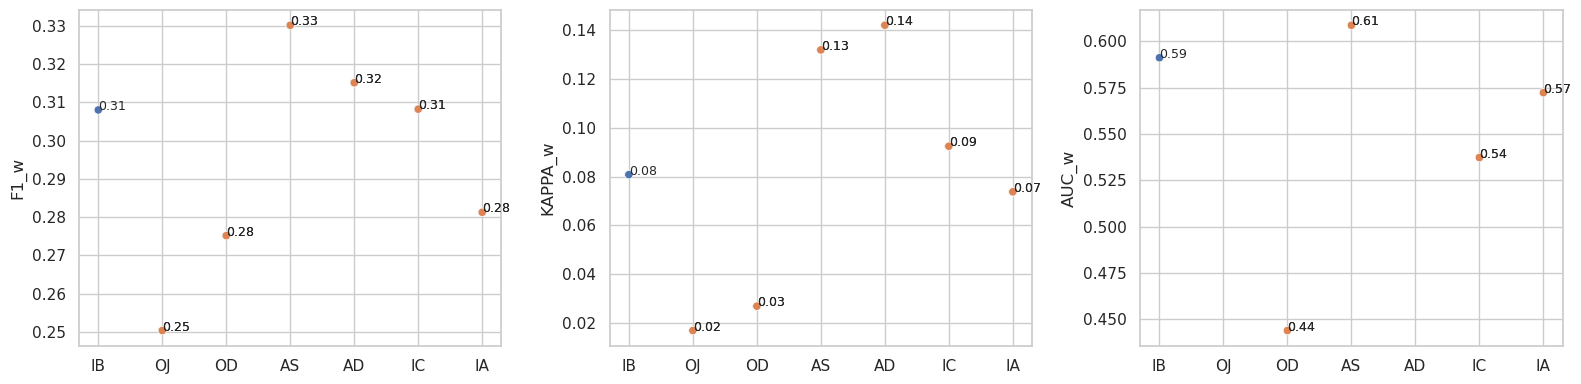

In [31]:
CSP_dict = {'IB': 0, 'OJ': 1, 'OD': 2, 'AS': 3, 'AD': 4, 'IC': 5, 'IA': 6}
# CSP_dict = {'OD': 0, 'AS': 1, 'AD': 2, 'IC': 3, 'IA': 4}
# IB: do not have overlap
# OJ: only have one positive sample
# OD: no positive samples

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

df_res_all['Label'] = 'All'
df_res_overlap['Label'] = 'Overlap'
df_res = pd.concat([df_res_all, df_res_overlap])
df_res_plot = df_res[df_res['Short_Name'].isin(CSP_dict.keys())]

sns.scatterplot(data=df_res_plot, x="Short_Name", y="AUC_w", hue='Label', ax=axs[2], legend=False)
axs[2].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="KAPPA_w", hue='Label', ax=axs[1], legend=False)
axs[1].set(xlabel=None)

sns.scatterplot(data=df_res_plot, x="Short_Name", y="F1_w", hue='Label', ax=axs[0], legend=False)
axs[0].set(xlabel=None)


for i, point in df_res_plot.iterrows(): 
    axs[2].text(CSP_dict[point['Short_Name']], point['AUC_w'], '{:.2f}'.format(point['AUC_w']), fontsize=9)
    axs[1].text(CSP_dict[point['Short_Name']], point['KAPPA_w'], '{:.2f}'.format(point['KAPPA_w']), fontsize=9)
    axs[0].text(CSP_dict[point['Short_Name']], point['F1_w'], '{:.2f}'.format(point['F1_w']), fontsize=9)
    
fig.tight_layout()
# plt.savefig('./test_cmrt.eps', dpi=600, bbox_inches='tight', format='eps')
# plt.savefig('./test_cmrt.png', dpi=600, bbox_inches='tight')
plt.show()

In [32]:
# sns.set_style("ticks")
# fig, ax = plt.subplots(figsize=(6, 6))

# sns.barplot(data=df_res, x="Short_Name", y="COUNT", hue='Label', ax=ax,)

# ax2 = ax.twinx()
# sns.pointplot(data=df_res[df_res['Label']=='All'], x="Short_Name", y="Class1/Class0", ax=ax2, 
#               label='Class1/Class0', color='tab:red')
# sns.pointplot(data=df_res[df_res['Label']=='Overlap'], x="Short_Name", y="Class1/Class0", ax=ax2, 
#               label='Class1/Class0', color='tab:orange')
# sns.pointplot(data=df_res, x="Short_Name", y="Consist_RATIO", ax=ax2, 
#               label='Consistency Ratio', color='tab:green')
# ax.set(xlabel='', ylabel='Count')
# ax2.set(xlabel='', ylabel='Ratio')

# plt.show()

In [33]:
# fig, axs = plt.subplots(2, 1, figsize=(9, 6))

# sns.pointplot(data=df_res_all, x="Short_Name", y="Class1/Class0", ax=axs[0], 
#               label='#Class1/#Class0', color='tab:blue')
# sns.pointplot(data=df_res_all, x="Short_Name", y="AUC", ax=axs[0], 
#               label='AUC', color='tab:red')
# sns.pointplot(data=df_res_all, x="Short_Name", y="F1", ax=axs[0], 
#               label='F1', color='tab:green')
# axs[0].set(xlabel=None, ylabel=None)
# axs[0].legend()

# sns.pointplot(data=df_res_overlap, x="Short_Name", y="Class1/Class0", ax=axs[1], 
#               label='#Class1/#Class0', color='tab:blue')
# sns.pointplot(data=df_res_overlap, x="Short_Name", y="AUC", ax=axs[1], 
#               label='AUC', color='tab:red')
# sns.pointplot(data=df_res_overlap, x="Short_Name", y="F1", ax=axs[1], 
#               label='F1', color='tab:green')
# axs[1].set(xlabel=None, ylabel=None)
# axs[1].legend()

# plt.show()

## 5. Compare with qGeoGNN

Give qGeoGNN an advantage that if there is one compound in the test set, we will account the paired on in the training set. 

In [34]:
dfs = []
qgeognn_res_path = '/data/yuhhong/qGeoGNN_rt/results/'
files_list = [f for f in os.listdir(qgeognn_res_path) if not f.endswith('_post.csv')]

for f in files_list:
    df_tmp = pd.read_csv(os.path.join(qgeognn_res_path, f), sep='\t', index_col=0)
    df_tmp['Column'] = f.replace('.csv', '')
    dfs.append(df_tmp)

df_qgeognn = pd.concat(dfs)

df_qgeognn = df_qgeognn[['SMILES', 'Column', 'Y_Pred']]

In [35]:
data_dfs = []
for csp in ['ADH', 'ODH', 'OJ', 'OD', 'AS', 'AD', 'IA', 'IC']:
    df_tmp = pd.read_csv('/data/yuhhong/qGeoGNN_rt/dataset/{}_charity_0823.csv'.format(csp), index_col=0)
    data_dfs.append(df_tmp)
    
df_qgeognn_data = pd.concat(data_dfs)

df_qgeognn_data = df_qgeognn_data.drop(['Unnamed: 0'], axis=1)

df_qgeognn_data = df_qgeognn_data[['index', 'SMILES', 'RT', 'Speed', 'Column']]

In [36]:
df_qgeognn = df_qgeognn.merge(df_qgeognn_data, on=['SMILES', 'Column'], how='left')

In [37]:
grouped = df_qgeognn.groupby(by=['index', 'Column'])
df1 = grouped.filter(lambda x: len(x) == 1)
df2 = grouped.filter(lambda x: len(x) > 1)

Half predicted & half labeled 

In [38]:
df1 = df_qgeognn_data[df_qgeognn_data['index'].isin(df1['index'])].merge(df1, on=['index', 'Column'], how='right')

df1 = df1[df1['SMILES_x'] != df1['SMILES_y']]

df1['RT_Pred'] = df1.apply(lambda x: x['Y_Pred']/x['Speed_y'], axis=1)

df1 = df1[(df1['RT_x'] != 0) & (df1['RT_y'] != 0) & (df1['RT_Pred'] != 0)]

df1['K2/K1'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_y']) - 2.9) / (min(x['RT_x'], x['RT_y']) - 2.9), axis=1)
df1['K2/K1_Pred'] = df1.apply(lambda x: (max(x['RT_x'], x['RT_Pred']) - 2.9) / (min(x['RT_x'], x['RT_Pred']) - 2.9), axis=1)

In [39]:
df1 = df1.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
df1['Pred_qgeognn'] = df1.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df1['Pred_qgeognn_b'] = df1['Pred_qgeognn'].apply(binary_cls)

df1.reset_index(drop=True, inplace=True)

In [40]:
df1['SMILES'] = df1['SMILES_x'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [41]:
df1 = df1.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [42]:
f1 = metrics.f1_score(df1['Class'], df1['Pred_qgeognn'], average='micro')
kappa = metrics.cohen_kappa_score(df1['Class'], df1['Pred_qgeognn'])
acc = metrics.accuracy_score(df1['Class'], df1['Pred_qgeognn'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
print(metrics.confusion_matrix(df1['Class'], df1['Pred_qgeognn']))

F1: 0.4980237154150198
KAPPA: 0.211780001962516
ACC: 0.4980237154150198

[[25  7 12  2]
 [ 9  6 21  3]
 [37 15 85  9]
 [ 3  3  6 10]]


In [43]:
pred = np.argmax([np.array(i.split(','), dtype=float) for i in df1.Pred.tolist()], axis=1)

f1 = metrics.f1_score(pred, df1['Class'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df1['Class'])
acc = metrics.accuracy_score(pred, df1['Class'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
print(metrics.confusion_matrix(df1['Class'], pred))

F1: 0.48221343873517786
KAPPA: 0.054893350062735435
ACC: 0.48221343873517786

[[ 10   4  31   1]
 [  6   6  25   2]
 [ 30   8 103   5]
 [  0   1  18   3]]


Totally predicted

In [44]:
df1

,index,SMILES_x,RT_x,Speed_x,Column,SMILES_y,Y_Pred,RT_y,Speed_y,RT_Pred,...,Pred_qgeognn,Pred_qgeognn_b,SMILES,MB,Pred,Pred_b,K2/K1_y,Y,Class_b,Class
0,11766,Clc1ccc(cc1)[C@@H]2C=C(OC(=O)[C@H]2Cc3ccccc3)c...,56.30,0.75,IA,Clc1ccc(cc1)[C@H]2C=C(OC(=O)[C@H]2Cc3ccccc3)c4...,26.850405,36.70,0.75,35.800540,...,2,1,O=C1OC(c2ccc(Cl)cc2)=CC(c2ccc(Cl)cc2)C1Cc1ccccc1,16,"0.9823006391525269,0.012940204702317715,0.0003...",0.270817,1.5799,2,1,2
1,3994,Cc1ccc(cc1)[S](=O)(=O)N2C(=O)C[C@@H](C=C2c3ccc...,101.20,0.70,IA,Cc1ccc(cc1)[S](=O)(=O)N2C(=O)C[C@H](C=C2c3cccc...,20.982698,104.90,0.70,29.975283,...,3,1,Cc1ccc(S(=O)(=O)N2C(=O)CC(c3cccs3)C=C2c2ccccc2...,16,"0.9901094436645508,3.7178382626734674e-05,0.00...",0.272834,1.1097,0,0,0
2,11124,Cc1ccc(cc1)[S](=O)(=O)N2C(=O)C[C@@H](C=C2c3ccc...,43.00,0.50,IA,Cc1ccc(cc1)[S](=O)(=O)N2C(=O)C[C@H](C=C2c3cccc...,20.982698,47.40,0.50,41.965397,...,0,0,Cc1ccc(S(=O)(=O)N2C(=O)CC(c3cccs3)C=C2c2ccccc2...,16,"0.9901094436645508,3.7178382626734674e-05,0.00...",0.272834,1.1097,0,0,0
3,8692,Clc1ccccc1[C@H]2CC(=O)N=C(S2)c3ccccc3,22.50,0.50,IA,Clc1ccccc1[C@@H]2CC(=O)N=C(S2)c3ccccc3,12.274199,25.90,0.50,24.548397,...,0,0,O=C1CC(c2ccccc2Cl)SC(c2ccccc2)=N1,16,"0.0015463014133274555,0.0026830483693629503,0....",0.729392,1.1735,1,0,1
4,11105,CCOC(=O)C1=C(OC(=O)C[C@@H]1c2ccc(cc2)[N+]([O-]...,42.60,1.00,IA,CCOC(=O)C1=C(OC(=O)C[C@H]1c2ccc(cc2)[N+]([O-])...,43.110252,46.50,1.00,43.110252,...,0,0,CCOC(=O)C1=C(C=Cc2ccc([N+](=O)[O-])cc2)OC(=O)C...,16,"0.8644449710845947,0.00012464779138099402,0.13...",0.325384,1.0982,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,864,CCOC(=O)[C@](C[N+]([O-])=O)(Sc1ccc2ccccc2c1)c3...,11.06,1.00,AD,CCOC(=O)[C@@](C[N+]([O-])=O)(Sc1ccc2ccccc2c1)c...,15.278447,10.32,1.00,15.278447,...,2,1,CCOC(=O)C(C[N+](=O)[O-])(Sc1ccc2ccccc2c1)c1ccc...,11,"0.0012755070347338915,0.002553599188104272,0.9...",0.729550,1.0997,1,0,1
249,1210,COc1ccc(CN2CC\C(=C/C[C@](C)(C(=O)OC2=O)c3ccc(F...,12.25,1.00,AD,COc1ccc(CN2CC\C(=C/C[C@@](C)(C(=O)OC2=O)c3ccc(...,13.961822,16.26,1.00,13.961822,...,2,1,COc1ccc(CN2CCC(c3ccccc3)=CCC(C)(c3ccc(F)cc3)C(...,11,"0.004732586909085512,0.004056784324347973,0.85...",0.727588,1.4289,2,1,2
250,3771,C[C@@]1(Cc2ccccc2)C(=O)c3cc(cc(O)c3C1=O)c4ccccc4,10.60,0.70,AD,C[C@]1(Cc2ccccc2)C(=O)c3cc(cc(O)c3C1=O)c4ccccc4,17.090475,18.60,0.70,24.414964,...,3,1,CC1(Cc2ccccc2)C(=O)c2cc(-c3ccccc3)cc(O)c2C1=O,11,"0.0012012424413114786,0.0014200491132214665,0....",0.730027,2.0390,3,1,3
251,8343,Clc1ccc(C[C@H]2SC(=O)N(Cc3c(Cl)cccc3Cl)C2=O)cc1,21.20,1.00,AD,Clc1ccc(C[C@@H]2SC(=O)N(Cc3c(Cl)cccc3Cl)C2=O)cc1,32.666424,13.00,1.00,32.666424,...,2,1,O=C1SC(Cc2ccc(Cl)cc2)C(=O)N1Cc1c(Cl)cccc1Cl,11,"0.0010226393351331353,0.0012916905106976628,0....",0.730148,1.8119,2,1,2


In [45]:
df2

,SMILES,Column,Y_Pred,index,RT,Speed
5,C[C@@]1(COc2cc(ccc12)C(=O)N3CCCCC3)Cc4ccccc4,IA,15.787141,7962,19.800,0.8
6,C[C@@]1(COc2cc(ccc12)C(=O)N3CCCCC3)Cc4ccccc4,IA,15.787141,8685,19.700,0.8
9,Cc1nn(c(C)c1C)C(=O)\C=C/[C@](C)(N(CCCO)Cc2cccc...,IA,3.526236,12254,6.937,1.0
36,C\C(=C/[C@@H]1CC(CN1C(=S)Nc2ccc(cc2)C(F)(F)F)(...,IA,8.270082,396,8.370,1.0
37,C\C(=C/[C@@H]1CC(CN1C(=S)Nc2ccc(cc2)C(F)(F)F)(...,IA,8.270082,485,9.380,1.0
...,...,...,...,...,...,...
819,CCO[P](=O)(OCC)[C@@]12CC(=CC(=O)N1[S](=O)(=O)O...,ODH,23.334263,10373,17.000,0.8
881,O=[S]1(=O)N[C@H](C=C(C=Cc2ccccc2)c3ccccc13)C4C...,AD,34.709103,6767,23.600,1.5
882,O=[S]1(=O)N[C@H](C=C(C=Cc2ccccc2)c3ccccc13)C4C...,AD,34.709103,8818,23.100,1.5
895,O=[S]1(=O)N[C@@H](C=C(C=Cc2ccccc2)c3ccccc13)C4...,AD,22.223713,6767,16.400,1.5


In [46]:
df2['RT_Pred'] = df2.apply(lambda x: x['Y_Pred'] / x['Speed'], axis=1)

df_alpha = df2.groupby('index').apply(lambda x: (x['RT'].max() - 2.9) / (x['RT'].min() -2.9)).to_frame(name='K2/K1')
df_alpha_pred = df2.groupby('index').apply(lambda x: (x['RT_Pred'].max() - 2.9) / (x['RT_Pred'].min() -2.9)).to_frame(name='K2/K1_Pred')

df2 = df_alpha.merge(df2, on='index', how='left')
df2 = df2.merge(df_alpha_pred, on='index', how='left')

In [47]:
df2 = df2.merge(df_csp, left_on='Column', right_on='Short_Name', how='left').dropna()
df2['Pred_qgeognn'] = df2.apply(lambda x: convert2cls(x['K2/K1_Pred'], x['CSP_Category']), axis=1)
df2['Pred_qgeognn_b'] = df2['Pred_qgeognn'].apply(binary_cls)

df2.reset_index(drop=True, inplace=True)

In [48]:
df2['SMILES'] = df2['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [49]:
df2 = df2.merge(df_cmrt, left_on=['SMILES', 'CSP_Encode'], right_on=['SMILES', 'MB'], how='inner')

In [50]:
f1 = metrics.f1_score(df2['Class'], df2['Pred_qgeognn'], average='micro')
kappa = metrics.cohen_kappa_score(df2['Class'], df2['Pred_qgeognn'])
acc = metrics.accuracy_score(df2['Class'], df2['Pred_qgeognn'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
print(metrics.confusion_matrix(df2['Class'], df2['Pred_qgeognn']))

F1: 0.5
KAPPA: 0.24242424242424243
ACC: 0.5

[[0 0 0 0]
 [4 0 0 0]
 [0 4 8 2]
 [0 0 0 2]]


In [51]:
pred = np.argmax([np.array(i.split(','), dtype=float) for i in df2.Pred.tolist()], axis=1)

f1 = metrics.f1_score(pred, df2['Class'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df2['Class'])
acc = metrics.accuracy_score(pred, df2['Class'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
print(metrics.confusion_matrix(df2['Class'], pred))

F1: 0.7
KAPPA: 0.0
ACC: 0.7

[[ 0  4  0]
 [ 0 14  0]
 [ 0  2  0]]


All

In [52]:
df_all = pd.concat([df1[['Class', 'Pred_qgeognn', 'Pred']],
                  df2[['Class', 'Pred_qgeognn', 'Pred']]])

In [53]:
f1 = metrics.f1_score(df_all['Class'], df_all['Pred_qgeognn'], average='micro')
kappa = metrics.cohen_kappa_score(df_all['Class'], df_all['Pred_qgeognn'])
acc = metrics.accuracy_score(df_all['Class'], df_all['Pred_qgeognn'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
print(metrics.confusion_matrix(df_all['Class'], df_all['Pred_qgeognn']))

F1: 0.4981684981684982
KAPPA: 0.2149903450591889
ACC: 0.4981684981684982

[[25  7 12  2]
 [13  6 21  3]
 [37 19 93 11]
 [ 3  3  6 12]]


In [54]:
pred = np.argmax([np.array(i.split(','), dtype=float) for i in df_all.Pred.tolist()], axis=1)

f1 = metrics.f1_score(pred, df_all['Class'], average='micro')
kappa = metrics.cohen_kappa_score(pred, df_all['Class'])
acc = metrics.accuracy_score(pred, df_all['Class'])

print('F1: {}\nKAPPA: {}\nACC: {}\n'.format(f1, kappa, acc))
print(metrics.confusion_matrix(df_all['Class'], pred))

F1: 0.4981684981684982
KAPPA: 0.06055963026223232
ACC: 0.4981684981684982

[[ 10   4  31   1]
 [  6   6  29   2]
 [ 30   8 117   5]
 [  0   1  20   3]]
